#### Select most differentially expressed genes between treatments

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests


def group_anova(geneid, df):
    '''2 way anova'''
    lst_treatment = ['A']*9+['B']*9+['C']*9+['D']*9
    lst_day = ['d3', 'd7', 'd14']*12
    if df.loc[geneid].mean()<=0:
        result = np.array([np.NaN,np.NaN,np.NaN])
    else:
        df_gene = pd.DataFrame(df.loc[geneid])
        df_gene['treatment'] = lst_treatment
        df_gene['day'] = lst_day
        df_melt = pd.melt(df_gene, id_vars=['treatment', 'day'], value_vars=[geneid])
        model = ols('value ~ C(treatment) + C(day) + C(treatment):C(day)', data = df_melt).fit()
        table = sm.stats.anova_lm(model, typ = 2)
        result = np.array(table['PR(>F)'][:3])
    return result

In [2]:
# read log2 normalized expression matrix
dfrlog = pd.read_csv('./../data/rlog_matrix.csv', index_col=0).rename_axis('geneid')

In [22]:
# 2 way anova for all genes
anova_ls = np.empty((len(dfrlog), 3))
for n in range(len(dfrlog)):
    anova_ls[n, :] = group_anova(list(dfrlog.index)[n], dfrlog)
dfpval = pd.DataFrame(anova_ls, index = dfrlog.index, columns = ['treatment', 'day', 'interaction'])

In [33]:
# multiple tests correction for p value
(_, dfpval['adj_treatment'],_, _) = multipletests(dfpval['treatment'], method='bonferroni')

In [45]:
# rank genes by treatment p value and select first 800 genes
grn_genes = dfpval.sort_values(by = 'adj_treatment')[:800].index

In [49]:
# revert log2 normalized value to original value (recommended by PoLoBag)
(2**dfrlog[dfrlog.index.isin(grn_genes)]-0.5).to_csv('./../data/grn_expression.txt', sep='\t')

#### Heatmap of selected genes

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['font.family']='arial'

In [4]:
# read log2 normalized expression of 800 genes for GRN inference
with open('./../data/grn_expression.txt', 'r') as f:
    lines = f.readlines()
genes = [line.split('\t')[0] for line in lines[1:]]
dfgrn = dfrlog[dfrlog.index.isin(genes)]

In [6]:
mtx = dfgrn.to_numpy()
# compute mean for biological replicates
means = np.zeros((mtx.shape[0], 12))
for n in range(12):
    a = n%3+(n//3)*9
    b = (n//3+1)*9
    means[:,n] = np.mean(mtx[:,a:b:3], axis=1)

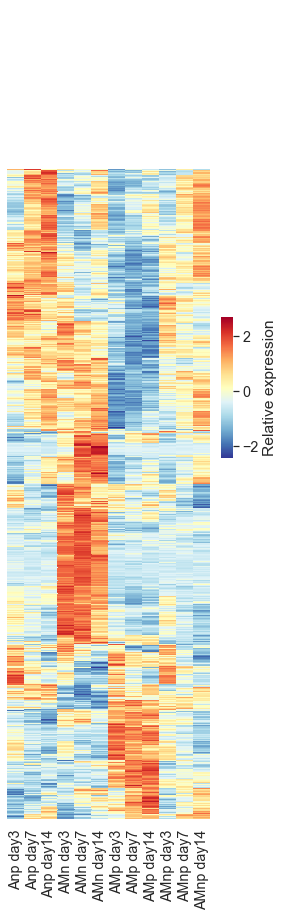

In [103]:
xlabels = [' '.join(x.split('_')[:2]) for x in \
            list(np.array(dfgrn.columns).reshape((4,9))[:,:3].flatten())]
fig = sns.clustermap(means, yticklabels=[],col_cluster=False, xticklabels=xlabels, 
                     z_score=0,cmap='RdYlBu_r', figsize=(4,13), method='average', 
                     cbar_kws={'shrink':0.08, 'label':'Relative expression'}, 
                     cbar_pos=(0.98, 0.5, 0.04, 0.15))
sns.set(font_scale=1.3)
fig.ax_row_dendrogram.set_visible(False)
#plt.savefig('/home/fenglab/Downloads/1F.png', dpi=400, pad_inches=0.1, bbox_inches='tight')

#### PCA of selected genes

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
colors = {'Anp':'#0088ff', 'AMn':'#ff6f00', 'AMp':'#00e883', 'AMnp':'#ffbf00'}

In [86]:
pc_scale = StandardScaler().fit_transform(dfrlog.to_numpy().T)
pca = PCA(n_components=2)
pca.fit(pc_scale)
pca_value = pca.transform(pc_scale)
pc_r = pca.explained_variance_ratio_*100

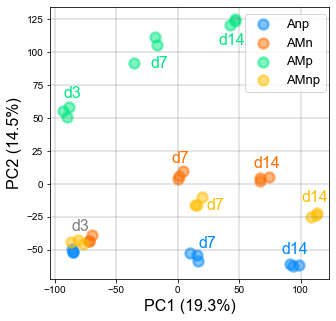

In [101]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
rcParams['font.family']='arial'
#rcParams.update({'font.size': 16})
plt.figure(figsize=(5, 5))

plt.scatter(pca_value[:9:, 0], pca_value[:9:,1], s=100, marker='o',linewidths=2.5,
            alpha=0.5, edgecolors=colors['Anp'], color = colors['Anp'], label='Anp')
plt.scatter(pca_value[9:18, 0], pca_value[9:18,1], s=100, marker='o', linewidths=2.5,
            alpha=0.5, edgecolors=colors['AMn'], color = colors['AMn'], label='AMn')
plt.scatter(pca_value[18:27, 0], pca_value[18:27,1], s=100, marker='o',linewidths=2.5,
            alpha=0.5, edgecolors=colors['AMp'], color = colors['AMp'], label='AMp')
plt.scatter(pca_value[27:, 0], pca_value[27:,1], s=100, marker='o',linewidths=2.5,
            alpha=0.5, edgecolors=colors['AMnp'], color = colors['AMnp'], label='AMnp')
plt.grid(linewidth=2, alpha=0.2, color='grey')
plt.legend(bbox_to_anchor=(1.01,1), prop={'size':13})

plt.text(pca_value[0,0], pca_value[0,1]+14, 'd3', color='grey', fontsize=16)
plt.text(pca_value[1,0], pca_value[1,1]+10, 'd7', color=colors['Anp'], fontsize=16)
plt.text(pca_value[2,0]-7, pca_value[2,1]+8, 'd14', color=colors['Anp'], fontsize=16)
plt.text(pca_value[10,0]-5, pca_value[10,1]+12, 'd7', color=colors['AMn'], fontsize=16)
plt.text(pca_value[11,0]-5, pca_value[11,1]+10, 'd14', color=colors['AMn'], fontsize=16)
plt.text(pca_value[18,0], pca_value[18,1]+10, 'd3', color=colors['AMp'], fontsize=16)
plt.text(pca_value[19,0]-5, pca_value[19,1]-17, 'd7', color=colors['AMp'], fontsize=16)
plt.text(pca_value[20,0]-10, pca_value[20,1]-15, 'd14', color=colors['AMp'], fontsize=16)
plt.text(pca_value[28,0]+4, pca_value[28,1]-10, 'd7', color=colors['AMnp'], fontsize=16)
plt.text(pca_value[29,0]-12, pca_value[29,1]+8, 'd14', color=colors['AMnp'], fontsize=16)

plt.xlabel('PC1 (' + str(pc_r[0])[:4] + '%)', fontsize=16)
plt.ylabel('PC2 (' + str(pc_r[1])[:4] + '%)', fontsize=16)
#plt.savefig('/home/fenglab/Downloads/1G.png', dpi=400, pad_inches=0.1, bbox_inches='tight')